# Model Train and Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
#from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
import pickle
import joblib
#from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
#import lightgbm as lgb
import os

In [4]:
#params
base_path = r"C:\Users\imate\Documents\24.9.Notebooks_training\Energy-predictor\data\2_processed"
base_path2 = r"C:\Users\imate\Documents\24.9.Notebooks_training\Energy-predictor\reports"

X_train_f = os.path.join(base_path, "2_X_train_new.ftr")
X_cv_f = os.path.join(base_path, "2_X_cv_new.ftr")
y_readings_tr_f = os.path.join(base_path2, "y_readings_tr_new.npy")
y_readings_cv_f = os.path.join(base_path2, "y_readings_cv_new.npy")


X_train= pd.read_feather(X_train_f) #city	country
X_cv= pd.read_feather(X_cv_f)
y_readings_tr= np.load(y_readings_tr_f)
y_readings_cv= np.load(y_readings_cv_f)


In [12]:
X_train.drop(['city','country'],axis=1,inplace=True)
X_cv.drop(['city','country'],axis=1,inplace=True)

- Decision tree

In [13]:
cv_error_array=[]
depth=[3,5,7,9,11,15]
for i in depth:
  d_reg=DecisionTreeRegressor(max_depth=i)
  d_reg.fit(X_train,y_readings_tr)
  pred_d_reg=d_reg.predict(X_cv)
  cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg)))
  print("rmse for max_depth:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg)))

rmse for max_depth: 3 is 389.73179667846654
rmse for max_depth: 5 is 378.6719269719423
rmse for max_depth: 7 is 382.3994942706788
rmse for max_depth: 9 is 405.98996403369637
rmse for max_depth: 11 is 405.9916210149411
rmse for max_depth: 15 is 405.98996403369637


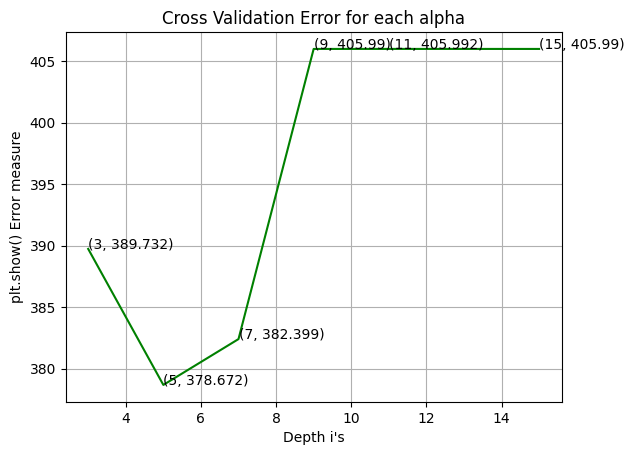

In [14]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(depth, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((depth[i],np.round(txt,3)), (depth[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Depth i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [15]:
d_reg=DecisionTreeRegressor(max_depth=depth[best_alpha],random_state=5)
d_reg.fit(X_train,y_readings_tr)
pred_d_reg_tr=d_reg.predict(X_train)
pred_d_reg_cv=d_reg.predict(X_cv)
print("Train rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_d_reg_tr)))
print("CV rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg_cv)))

Train rmse for max_depth: 5 is 5.831674171473801
CV rmse for max_depth: 5 is 401.99127489934915


In [22]:
base_path_models = r"C:\Users\imate\Documents\24.9.Notebooks_training\Energy-predictor\models"

model_dt = os.path.join(base_path_models, "decision_tree_reg.sav")
#Save the models to a pickle file for making predictions on test data in future
joblib.dump(d_reg,model_dt)

['C:\\Users\\imate\\Documents\\24.9.Notebooks_training\\Energy-predictor\\models\\decision_tree_reg.sav']

- LGBM Regressor

In [19]:
import lightgbm as lgb
lgb_estimators=[75,150,500,1000,2000]
cv_error_array=[]
for i in lgb_estimators:
    lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i,objective='rmse', n_jobs=-1)
    lgb_reg.fit(X_train,y_readings_tr)
    pred_reg_lgb=lgb_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 203080, number of used features: 17
[LightGBM] [Info] Start training from score 127.069404
rmse for estimators: 75 is 405.3637346451929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 203080, number of used features: 17
[LightGBM] [Info] Start training from score 127.069404
rmse for estimators: 150 is 405.39080815874956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007198 seconds.
You can set `force_col_wise=true` to remove the ov

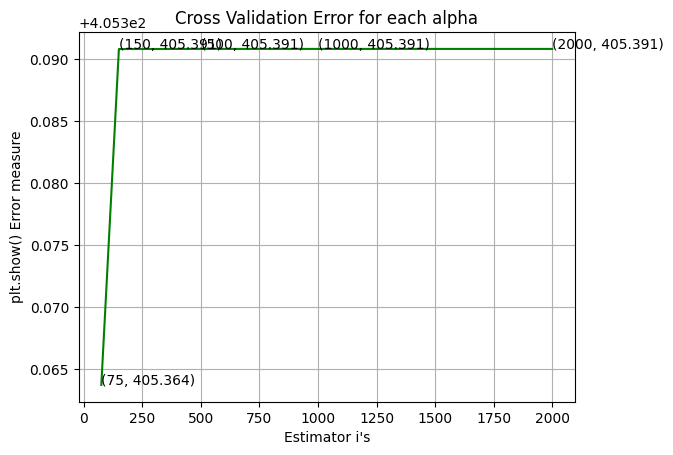

In [20]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [21]:
lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=lgb_estimators[best_alpha], objective='rmse',n_jobs=-1)
lgb_reg.fit(X_train,y_readings_tr)
pred_reg_lgb_cv=lgb_reg.predict(X_cv)
pred_reg_lgb_tr=lgb_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb_cv)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 203080, number of used features: 17
[LightGBM] [Info] Start training from score 127.069404
Train rmse for estimators: 75 is 0.08313709235157717
CV rmse for estimators: 75 is 405.3637346451929


In [23]:
model_dt = os.path.join(base_path_models, "lgb_reg.sav")
#Save the models to a pickle file for making predictions on test data in future
joblib.dump(d_reg,model_dt)

['C:\\Users\\imate\\Documents\\24.9.Notebooks_training\\Energy-predictor\\models\\lgb_reg.sav']

- LGBM RF Regressor

In [24]:
cv_error_array=[]
for i in lgb_estimators:
    rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=i, n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
    rf_reg.fit(X_train,y_readings_tr)
    pred_rf_reg=rf_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_rf_reg)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_rf_reg)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 203080, number of used features: 17
[LightGBM] [Info] Start training from score 127.069404
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[Li

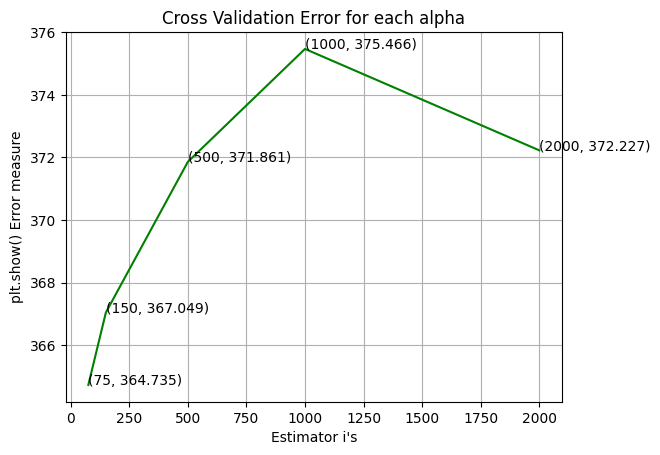

In [25]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [26]:
rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=lgb_estimators[best_alpha], n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
rf_reg.fit(X_train,y_readings_tr)
pred_reg_lgb_cv=rf_reg.predict(X_cv)
pred_reg_lgb_tr=rf_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb_cv)))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 203080, number of used features: 17
[LightGBM] [Info] Start training from score 127.069404
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[Li

In [27]:
model_dt = os.path.join(base_path_models, "rf_reg.sav")
#Save the models to a pickle file for making predictions on test data in future
joblib.dump(d_reg,model_dt)

['C:\\Users\\imate\\Documents\\24.9.Notebooks_training\\Energy-predictor\\models\\rf_reg.sav']

- catboost

In [28]:
import catboost as cb
cb_estimators=[75,150,500,1000,1500]
cv_error_array=[]
for i in cb_estimators:
    cb_reg=cb.CatBoostRegressor(n_estimators=i)
    cb_reg.fit(X_train,y_readings_tr)
    pred_reg_cb=cb_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb)))

Learning rate set to 0.5
0:	learn: 113.6943165	total: 148ms	remaining: 10.9s
1:	learn: 57.9735451	total: 157ms	remaining: 5.73s
2:	learn: 29.5595549	total: 168ms	remaining: 4.02s
3:	learn: 14.9216145	total: 178ms	remaining: 3.15s
4:	learn: 7.8683070	total: 187ms	remaining: 2.62s
5:	learn: 3.9607032	total: 198ms	remaining: 2.28s
6:	learn: 1.9848439	total: 210ms	remaining: 2.04s
7:	learn: 1.0300645	total: 221ms	remaining: 1.85s
8:	learn: 0.5260901	total: 232ms	remaining: 1.7s
9:	learn: 0.2688596	total: 244ms	remaining: 1.58s
10:	learn: 0.1347428	total: 254ms	remaining: 1.48s
11:	learn: 0.0680294	total: 264ms	remaining: 1.39s
12:	learn: 0.0343698	total: 274ms	remaining: 1.31s
13:	learn: 0.0171909	total: 284ms	remaining: 1.24s
14:	learn: 0.0089340	total: 295ms	remaining: 1.18s
15:	learn: 0.0046678	total: 304ms	remaining: 1.12s
16:	learn: 0.0023375	total: 314ms	remaining: 1.07s
17:	learn: 0.0011723	total: 324ms	remaining: 1.03s
18:	learn: 0.0005882	total: 333ms	remaining: 982ms
19:	learn: 0

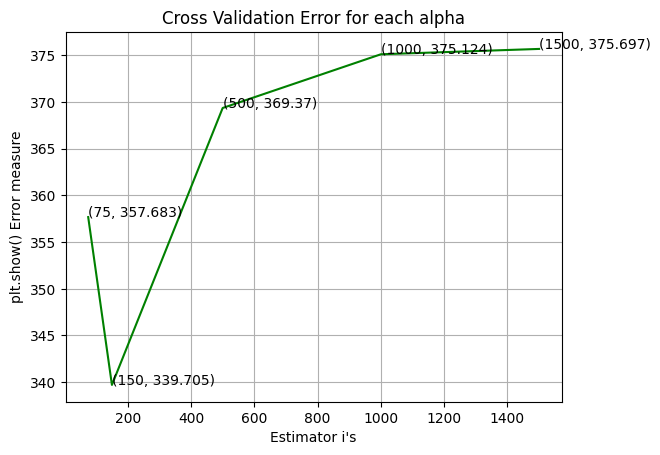

In [29]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(cb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((cb_estimators[i],np.round(txt,3)), (cb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [30]:
cb_reg=cb.CatBoostRegressor(n_estimators=cb_estimators[best_alpha])
cb_reg.fit(X_train,y_readings_tr)
pred_reg_cb_cv=cb_reg.predict(X_cv)
pred_reg_cb_tr=cb_reg.predict(X_train)
print("Train rmse for estimators:", cb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_cb_tr)))
print("CV rmse for estimators:", cb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb_cv)))


Learning rate set to 0.44323
0:	learn: 126.2228603	total: 11.5ms	remaining: 1.71s
1:	learn: 71.1384406	total: 21.8ms	remaining: 1.61s
2:	learn: 40.0224163	total: 32.7ms	remaining: 1.6s
3:	learn: 22.3588759	total: 44.1ms	remaining: 1.61s
4:	learn: 12.5618946	total: 54.5ms	remaining: 1.58s
5:	learn: 6.9960253	total: 68.1ms	remaining: 1.64s
6:	learn: 3.9424487	total: 82.4ms	remaining: 1.68s
7:	learn: 2.2250750	total: 97.6ms	remaining: 1.73s
8:	learn: 1.2414162	total: 113ms	remaining: 1.78s
9:	learn: 0.7120801	total: 131ms	remaining: 1.83s
10:	learn: 0.4037089	total: 147ms	remaining: 1.86s
11:	learn: 0.2285955	total: 167ms	remaining: 1.92s
12:	learn: 0.1296403	total: 184ms	remaining: 1.94s
13:	learn: 0.0760014	total: 200ms	remaining: 1.95s
14:	learn: 0.0423269	total: 217ms	remaining: 1.95s
15:	learn: 0.0235728	total: 232ms	remaining: 1.94s
16:	learn: 0.0134068	total: 249ms	remaining: 1.95s
17:	learn: 0.0076388	total: 263ms	remaining: 1.93s
18:	learn: 0.0043117	total: 278ms	remaining: 1.91s

In [33]:
model_dt = os.path.join(base_path_models, "cb_reg.sav")
#Save the models to a pickle file for making predictions on test data in future
joblib.dump(cb_reg,model_dt)

['C:\\Users\\imate\\Documents\\24.9.Notebooks_training\\Energy-predictor\\models\\cb_reg.sav']

- MLP

In [41]:
from keras import Sequential
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout,BatchNormalization
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1
from tqdm import tqdm

In [36]:
#https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [42]:
inp_dim=X_train.shape[1]
beta=[2048,1024,512,256,128,64]
earlystop= EarlyStopping(monitor='val_loss', mode='min', patience=3)
for i in tqdm(beta):

  model=Sequential()
  model.add(Dense(i, activation='relu', input_shape=(inp_dim,)))
  model.add(Dense(i*0.5, activation='relu'))
  model.add(Dense(i*0.25, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='linear'))
  opt=Adam(0.0001)
  model.compile(optimizer=opt, loss= root_mean_squared_error)
  model.fit(X_train, y_readings_tr,epochs=15,batch_size=2048,validation_data=(X_cv,y_readings_cv),callbacks=earlystop)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/15
100/100 [==============================] - 12s 111ms/step - loss: 210.8170 - val_loss: 258.4330
Epoch 2/15
100/100 [==============================] - 11s 106ms/step - loss: 183.4950 - val_loss: 240.8629
Epoch 3/15
100/100 [==============================] - 11s 107ms/step - loss: 120.9622 - val_loss: 242.6690
Epoch 4/15
100/100 [==============================] - 11s 107ms/step - loss: 51.8901 - val_loss: 242.1217
Epoch 5/15
100/100 [==============================] - 10s 102ms/step - loss: 25.9565 - val_loss: 240.4369
Epoch 6/15
100/100 [==============================] - 10s 100ms/step - loss: 17.6457 - val_loss: 236.7304
Epoch 7/15
100/100 [==============================] - 10s 103ms/step - loss: 13.9473 - val_loss: 234.2729
Epoch 8/15
100/100 [==============================] - 10s 102ms/step - loss: 12.0172 - val_loss: 231.5888
Epoch 9/15
100/100 [==============================] - 10s 102ms/step - loss: 10.5741 - val_loss: 233.5195
Epoch 10/15
100/100 [======================

 17%|█▋        | 1/6 [02:35<12:57, 155.43s/it]

Epoch 1/15
100/100 [==============================] - 4s 34ms/step - loss: 220.7693 - val_loss: 272.4733
Epoch 2/15
100/100 [==============================] - 3s 34ms/step - loss: 197.5469 - val_loss: 258.9753
Epoch 3/15
100/100 [==============================] - 3s 34ms/step - loss: 179.4158 - val_loss: 245.4098
Epoch 4/15
100/100 [==============================] - 3s 32ms/step - loss: 135.7735 - val_loss: 248.0350
Epoch 5/15
100/100 [==============================] - 3s 33ms/step - loss: 73.4490 - val_loss: 248.4828
Epoch 6/15
100/100 [==============================] - 3s 34ms/step - loss: 38.3006 - val_loss: 242.5642
Epoch 7/15
 81/100 [=======================>......] - ETA: 0s - loss: 24.8633

In [ ]:
inp_dim=X_train.shape[1]
earlystop= EarlyStopping(monitor='val_loss', mode='min', patience=3)

model=Sequential()
model.add(Dense(2048, activation='relu', input_shape=(inp_dim,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
opt=Adam(0.0001)
model.compile(optimizer=opt, loss= root_mean_squared_error)
model.fit(X_train, y_readings_tr,epochs=15,batch_size=2048,validation_data=(X_cv,y_readings_cv),callbacks=earlystop)

- Stacking Regressor

In [ ]:
X_train['meter_reading']=y_readings_tr
X_train.shape

In [ ]:
#dividing the train data into two sets
X_tr_d1, X_tr_d2= train_test_split(X_train, test_size=0.50, shuffle=False)
X_tr_d2.reset_index(inplace=True)
X_tr_d2.drop('index', axis=1, inplace=True)

In [ ]:
y_tr_d2= X_tr_d2['meter_reading']
X_tr_d2.drop('meter_reading', axis=1, inplace=True)

In [ ]:

def make_20_model(df):
 """
 train 20 models with 20 different samples
 """
 model_list = []
 for i in tqdm(range(20)):
   #Sample rows from D1
    df_tr=df.sample(n=3500000, replace=True) 
    y_tr= df_tr['meter_reading']
    df_tr.drop('meter_reading', axis=1, inplace=True)

    #train GBDT on D1
    gb_trees = lgb.LGBMRegressor(n_estimators=2000,objective='regression', n_jobs=-1)
    model_list.append(gb_trees.fit(df_tr,y_tr))

 return model_list


In [ ]:
model_list= make_20_model(X_tr_d1)

In [ ]:
#Predict on D2 using above models
def predict_base_models(models,data):
  y_pred=[]
  for i in tqdm(models):
    y_hat=i.predict(data)
    y_pred.append(y_hat)
  
  return y_pred
y_predicted=predict_base_models(model_list,X_tr_d2)

In [ ]:
#create dataset with the above predictions
def create_dataset(predict_values):
  pred_values=np.reshape(predict_values[0], (len(predict_values[0]),1))
  for i in range(1,len(predict_values)):
    pred= np.reshape(predict_values[i], (len(predict_values[i]),1))
    pred_values= np.hstack((pred_values,pred))
  
  return pred_values



In [ ]:
pred_dataset=create_dataset(y_predicted)
lgb_estimators=[75,150,500,1000,2000,3000]
cv_error_array=[]
#train model on the dataset created by predictions
for i in lgb_estimators:
  lgb_model=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i, objective='regression',n_jobs=-1)
  lgb_model.fit(pred_dataset,y_tr_d2)
  cv_pred= predict_base_models(model_list,X_cv)
  pred_data_cv=create_dataset(cv_pred)
  pred_stack_cv=lgb_model.predict(pred_data_cv)
  print("CV rmse for stacking regressor with estimators:",i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_stack_cv)))

In [ ]:
lgb_model=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=2000, objective='regression',n_jobs=-1)
lgb_model.fit(pred_dataset,y_tr_d2)
cv_pred= predict_base_models(model_list,X_cv)
pred_data_cv=create_dataset(cv_pred)
pred_stack_cv=lgb_model.predict(pred_data_cv)
print("CV rmse for stacking regressor with estimators:",2000,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_stack_cv)))


In [ ]:
import pickle

file_name = r"C:\Users\imate\Documents\24.9.Notebooks_training\Energy-predictor\models\model_list.pkl"
open_file = open(file_name, "wb")
pickle.dump(model_list, open_file)
open_file.close()

file_name = "C:\Users\imate\Documents\24.9.Notebooks_training\Energy-predictor\models\stacking_reg.pkl"
open_file = open(file_name, "wb")
pickle.dump(lgb_model, open_file)
open_file.close()